# Henon - Heiles System 
A hamiltonian system that is integrable and exhibits chaotic orbits.
$$
H(q_{1},q_{2},p_{1},p_{2}) = \frac{1}{2}(q_{1}^{2}+q_{2}^{2}+p_{1}^{2}+p_{1}^{2})+\lambda(q_{1}^{2}q_{2}-\frac{q_{2}^{3}}{3})
$$
We'll try and train an Hamiltonian NN and a baseline NN to model this system

In [1]:
import matplotlib.pyplot as plt
import torch, time, sys
import numpy as np
from math import sqrt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = '.'
sys.path.append(EXPERIMENT_DIR)

from baseline_nn import BLNN
from hnn import HNN
from utils import L2_loss, to_pickle, from_pickle
from data import DynamicalSystem

## Set some notebook constants

In [2]:
DPI = 300
FORMAT = 'pdf'
DSR = 0.1

def get_args():
    return {'input_dim': 4, # two bodies, each with q_x, q_y, p_z, p_y
         'hidden_dim': [200,200],
         'learn_rate': 1e-3,
         'input_noise': 0.0,
         'batch_size': 100,
         'total_steps': 4000,
         'print_every': 200,
         'hamiltonian': "(q1**2+q2**2+p1**2+p2**2)/(2)+ (q1**2*q2 - (q2**3)/(3))",
         'energy': 0.15, #0.125,
         'integrator': "RK45", #[RK45, RK4, Symplectic]
         'verbose': True,
         'name': 'Henon_Heiles_DSR_{}'.format(DSR),
         'seed': 0,
         'save_dir': '{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Visualize one example from dataset

In [5]:
args = ObjectView(get_args())
np.random.seed()

tspan = [0,500]
tpoints = int(tspan[1]*(1.0/DSR))
print('No. of orbit points : {}'.format(tpoints))
state_symbols = ['q1','q2','p1','p2']
sys = DynamicalSystem(sys_hamiltonian=args.hamiltonian,state_symbols=state_symbols,
                      tspan=tspan,timesteps=tpoints,integrator=args.integrator,
                      symplectic_order=4)
result = False
while not result:
    with np.errstate(invalid='raise'):
        try:
            q1, q2 = 0.3*(1-2*np.random.random(2))
            p1= 0.2*(1-2*np.random.random())
            p2 = abs(sqrt(2*(args.energy - (q1**2*q2 - q2**3/3.0))-(q1**2+q2**2+p1**2)))
            result = True 
        except FloatingPointError:
            continue

state = np.array([q1, q2, p1, p2])

print('Initial Condition : {}'.format(state))
print('Energy : {}'.format(sys.get_energy(state)))

orbit, settings = sys.get_orbit(state)

print('Shape of the orbit : {}'.format(orbit.shape))


No. of orbit points : 5000
Initial Condition : [ 0.22539256 -0.06424995  0.05618615  0.49826144]
Energy : 0.15
Shape of the orbit : (4, 5000)


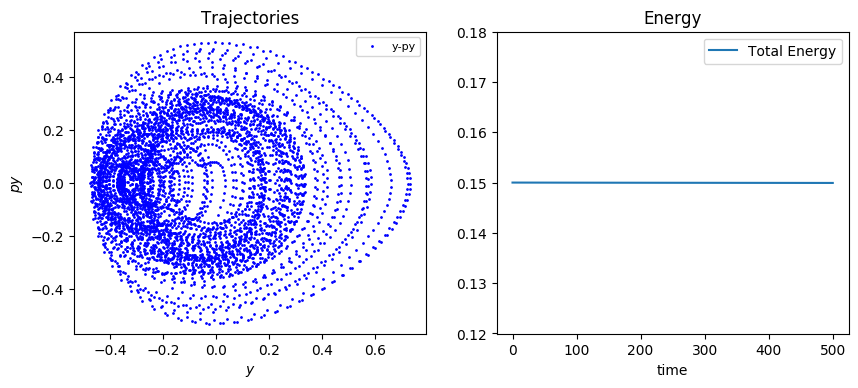

In [7]:
# draw trajectory
fig = plt.figure(figsize=[10,4], dpi=100)

plt.subplot(1,2,1)
plt.title('Trajectories')
plt.plot(orbit[1,:], orbit[3,:],  '.b', label='y-py',markersize=2)
plt.axis('equal')
plt.xlabel('$y$') ; plt.ylabel('$py$')
plt.legend(fontsize=8, loc='best')

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
z = sys.get_energy(orbit)
plt.plot(settings['t_eval'], z, label='Total Energy')
plt.legend()
y_lim = (0.8*z.min(),1.2*z.max())
plt.ylim(y_lim)



plt.show()
#fig.savefig('{}/orbits-dataset_{}_nlayers_{}_energy_{}_integrator_{}.{}'.format(
#                                                    args.fig_dir,args.name,len(args.hidden_dim),
#                                                    args.energy,args.integrator,FORMAT))

## Load Trained models

In [9]:
def load_model(args, baseline=False):
    
    if baseline:
        output_dim = args.input_dim
        model = BLNN(args.input_dim, args.hidden_dim,output_dim,'Tanh')
    else:
        output_dim = 1
        nn_model = BLNN(args.input_dim, args.hidden_dim,output_dim,'Tanh')
        model = HNN(args.input_dim,baseline_model=nn_model)
    
    case = 'baseline' if baseline else 'hnn'
    #print('---->',case)
    path = "{}/{}_nlayers_{}-orbits-{}_integrator_{}.tar".format(args.save_dir, args.name, 
                                                    len(args.hidden_dim),case,args.integrator)
    print('----------->', path)
    model.load_state_dict(torch.load(path),strict=False)
    return model

args = ObjectView(get_args())
base_model = load_model(args, baseline=True)
hnn_model = load_model(args, baseline=False)
print('----->',base_model)
print('\n\n')
print('----->',hnn_model)

-----------> ./Henon_Heiles_DSR_0.1_nlayers_2-orbits-baseline_integrator_RK45.tar


FileNotFoundError: [Errno 2] No such file or directory: './Henon_Heiles_DSR_0.1_nlayers_2-orbits-baseline_integrator_RK45.tar'

## What has the baseline learned?

In [17]:
# for integrating a vector field parameterized by a NN or HNN
def model_update(t, state, model):
    state = state.reshape(-1,4)
    #print('----->',state.shape)
    deriv = np.zeros_like(state)
    np_x = state # drop mass
   
    #np_x = np_x.T.flatten()[None, :]
    #print('----->',np_x.shape)
   
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    #print('----->',x.shape)
    dx_hat = model.time_derivative(x)
    #print('----->',dx_hat.shape)
    deriv= dx_hat.detach().data.numpy()
    #print('----->',deriv.reshape(-1).shape)
    return deriv.reshape(-1)

### Integrate trajectories

In [ ]:
print(sys.time_points)

In [18]:
np.random.seed(553) # 63553
sys.time_points = 10*(tspan[1])
q1, q2 = 0.3*(1-2*np.random.random(2))
p1= 0.2*(1-2*np.random.random())
sys.integrator ='RK45'
p2 = abs(sqrt(2*(args.energy - (q1**2*q2 - q2**3/3.0))-(q1**2+q2**2+p1**2)))
state = np.array([q1, q2, p1, p2])
print('------->',state)
sys.external_update_fn = None
orbit, settings = sys.get_orbit(state)
print('------->',orbit.shape)


-------> [-0.23568833  0.14813289 -0.13392316  0.37454239]
-------> (4, 50000)


In [19]:
update_fn = lambda t, y0: model_update(t, y0, base_model)
sys.external_update_fn = update_fn
sys.integrator = 'RK45'
base_orbit, settings = sys.get_orbit(state)
print('------->',base_orbit.shape)

Using extrenal  function...
-------> (4, 50000)


In [ ]:
print(orbit.shape)
print(base_orbit.shape)
print(len(settings['t_eval']))


### Draw trajectories

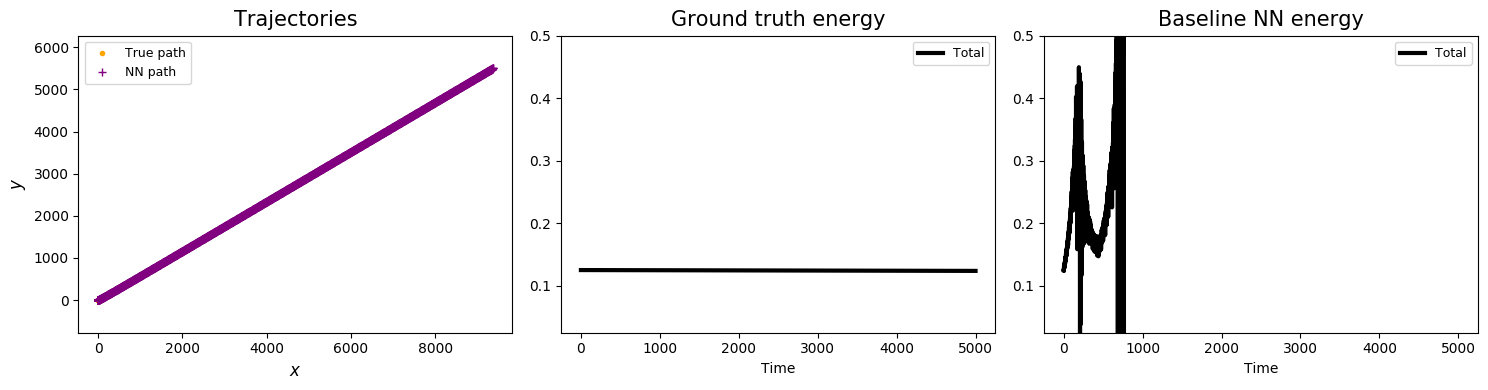

In [20]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple']

plt.plot(orbit[1,::10], orbit[3,::10], '.', c=colors[0], label='True path', linewidth=2)
    
plt.plot(base_orbit[1,::10], base_orbit[3,::10], '+', c=colors[1], label='NN path', linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_etot = sys.get_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
#plt.xlim(*settings['tspan'])
ymin = 0.2*real_etot.min() 
ymax = 4*real_etot.max()
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], sys.get_energy(base_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
#plt.xlim(*settings['tspan'])
plt.ylim(ymin, ymax)
#plt.yscale('log')

plt.tight_layout() ; plt.show()
fig.savefig('{}/orbits-baseline_{}_nlayers_{}integrator_{}.{}'.format(args.fig_dir, args.name,
                                                len(args.hidden_dim),args.integrator, FORMAT))

## What has the HNN learned?

### Integrate trajectories

In [21]:
np.random.seed(13553)

q1, q2 = 0.3*(1-2*np.random.random(2))
p1= 0.2*(1-2*np.random.random())

sys.integrator = 'RK45'
print(sys.integrator)

p2 = abs(sqrt(2*(args.energy - (q1**2*q2 - q2**3/3.0))-(q1**2+q2**2+p1**2)))
state = np.array([q1, q2, p1, p2])
print('------->',state)

sys.external_update_fn = None
orbit, settings = sys.get_orbit(state)
print(sys.update_fn)
print('------->',orbit.shape)
sys.integrator="RK45"
update_fn = lambda t, y0: model_update(t, y0, hnn_model)
sys.external_update_fn = update_fn
print(sys.update_fn)
print(sys.integrator)
hnn_orbit, settings = sys.get_orbit(state)
print('------->',hnn_orbit.shape)

RK45
-------> [-0.27828367  0.26725846  0.01451255  0.26879895]
<bound method DynamicalSystem.update of <data.DynamicalSystem object at 0x7f0a6b527860>>
-------> (4, 50000)
<bound method DynamicalSystem.update of <data.DynamicalSystem object at 0x7f0a6b527860>>
RK45
Using extrenal  function...
-------> (4, 50000)


### Draw trajectories

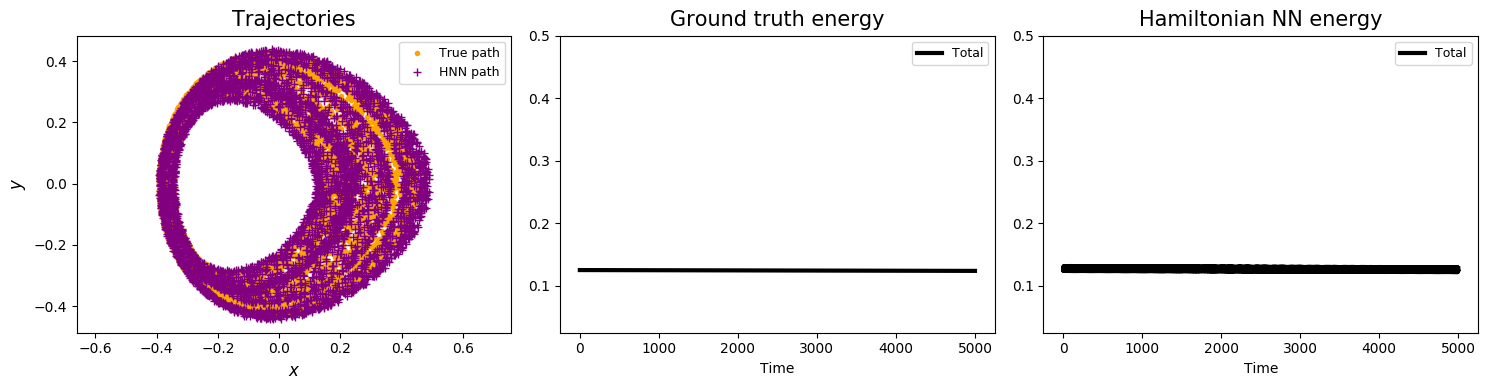

In [22]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple']

plt.plot(orbit[1,::10], orbit[3,::10], '.', c=colors[0], label='True path', linewidth=2)
    

plt.plot(hnn_orbit[1,::10], hnn_orbit[3,::10], '+', c=colors[1], label='HNN path', linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_etot = sys.get_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
#plt.xlim(*settings['t_span'])
ymin = 0.2*real_etot.min()
ymax = 4*real_etot.max()
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Hamiltonian NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], sys.get_energy(hnn_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
#plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()
fig.savefig('{}/orbits-hnn-{}_nlayers_{}_integrator_{}.{}'.format(args.fig_dir,args.name,
                                                len(args.hidden_dim),args.integrator,FORMAT))

# How does the poincare section look like ?


In [32]:
def get_poincare_section(orbit):
    '''
        Takes in an orbit (x,y,x_dot,y_dot) and spits out a poincare section (y,y_dot) as a tuple.
    '''
    x, y, x_dot, y_dot = orbit[0], orbit[1], orbit[2], orbit[3]
    y_poincare = []
    y_dot_poincare = []
    for i in range(len(x) - 1):
        if (x[i] * x[i + 1] < 0.0):
            y_poincare.append(0.5 * (y[i] + y[i + 1]))
            y_dot_poincare.append(0.5 * (y_dot[i] + y_dot[i + 1]))

    return y_poincare, y_dot_poincare

def get_random_intial_conditons(energy):
    q1, q2 = 0.3 * (1 - 2 * np.random.random(2))
    p1 = 0.2 * (1 - 2 * np.random.random())
    p2 = abs(np.sqrt(2 * (energy - (q1**2 * q2 - q2**3 / 3.0)) -
                     (q1**2 + q2**2 + p1**2)))

    initial_state = np.array([q1, q2, p1, p2])
    return initial_state


In [33]:
# calculates 'n' different true orbits corresponding to the same energy
n_orbits = 10
np.random.seed(13353)
energy = 0.1
orbit_set = []
sys.tspan = [1, 4000]
sys.time_points = 400000
sys.external_update_fn = None
for i in range(n_orbits):
    y0 = get_random_intial_conditons(energy)
    sol, t = sys.get_orbit(state=y0)
    orbit_set.append(sol)




In [34]:
# calculates 'n' different learned-hnn orbits corresponding to the same energy
hnn_orbit_set = []
np.random.seed(13353)
update_fn = lambda t, y0: model_update(t, y0, hnn_model)
for i in range(n_orbits):
    sys.external_update_fn = update_fn
    y0 = get_random_intial_conditons(energy)
    sol, t = sys.get_orbit(state=y0)
    hnn_orbit_set.append(sol)

Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...


In [35]:
# calculates 'n' different learned-baseline orbits corresponding to the same energy
baseline_orbit_set = []
np.random.seed(13353)
update_fn = lambda t, y0: model_update(t, y0, base_model)
for i in range(n_orbits):
    sys.external_update_fn = update_fn
    y0 = get_random_intial_conditons(energy)
    sol, t = sys.get_orbit(state=y0)
    baseline_orbit_set.append(sol)

Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...
Using extrenal  function...


In [36]:
# get the poincare sections for corresponding true orbits 
y = []
y_dot = []
for i in range(n_orbits):
    y_tmp, y_dot_tmp = get_poincare_section(orbit_set[i])
    y.append(y_tmp)
    y_dot.append(y_dot_tmp)


In [37]:
# get the poincare sections for corresponding hnn orbits 
hnn_y = []
hnn_y_dot = []
for i in range(n_orbits):
    y_tmp, y_dot_tmp = get_poincare_section(hnn_orbit_set[i])
    hnn_y.append(y_tmp)
    hnn_y_dot.append(y_dot_tmp)

In [38]:
# get the poincare sections for corresponding baseline orbits 
baseline_y = []
baseline_y_dot = []
for i in range(n_orbits):
    y_tmp, y_dot_tmp = get_poincare_section(baseline_orbit_set[i])
    baseline_y.append(y_tmp)
    baseline_y_dot.append(y_dot_tmp)

# Plotting the poincare section of the true trajectories 

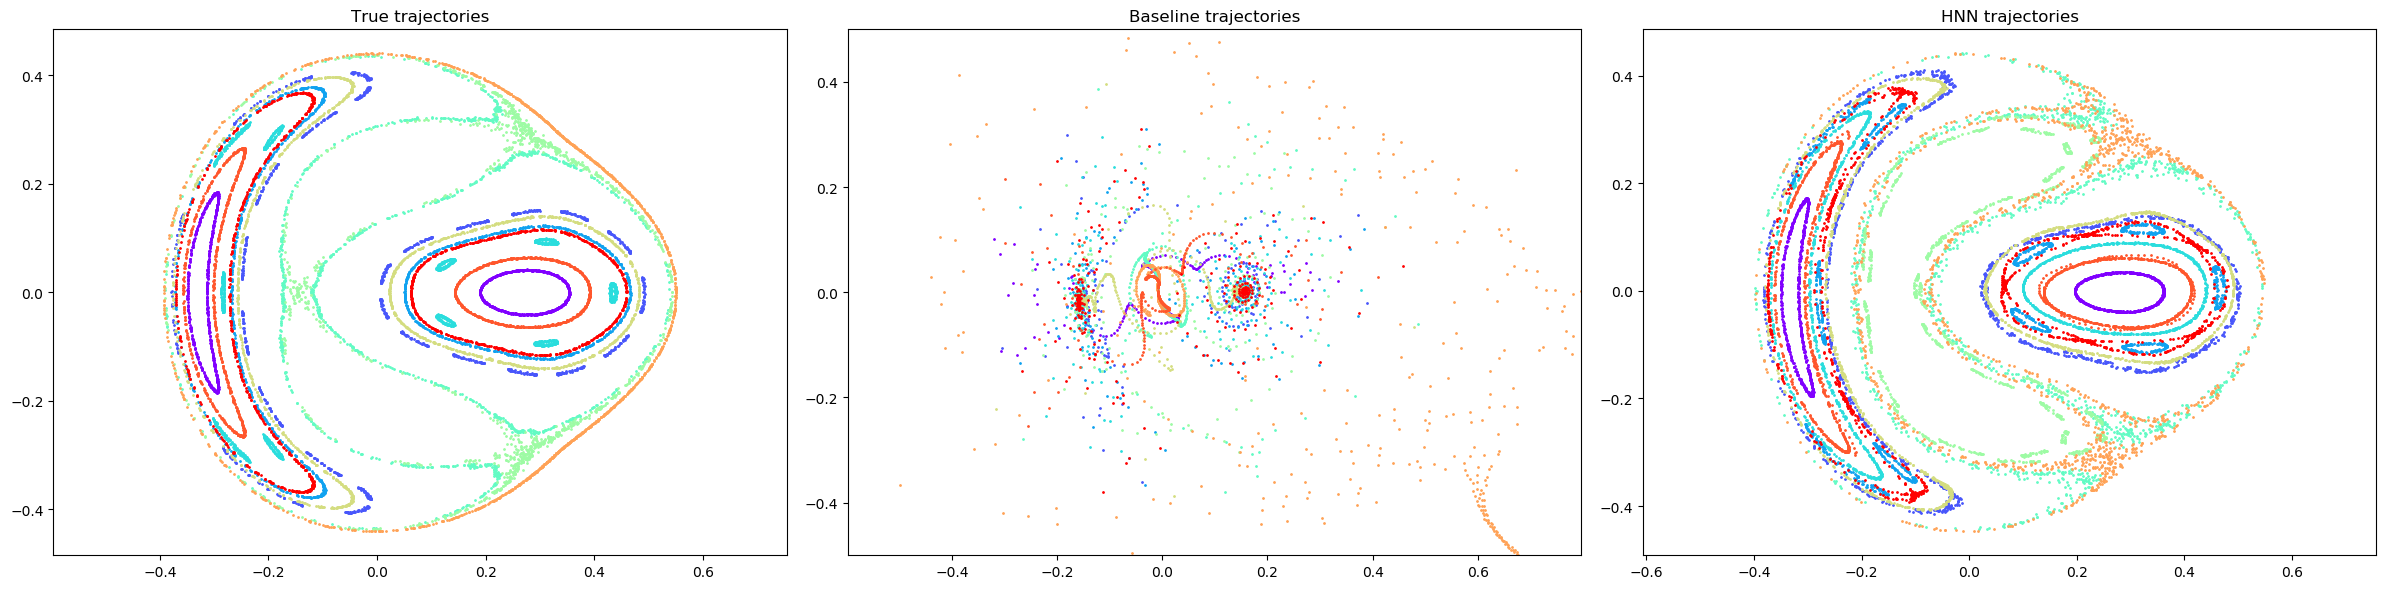

In [39]:
import matplotlib
from matplotlib import cm
colors = matplotlib.cm.rainbow(np.linspace(0, 1, n_orbits))
fig = plt.figure(figsize=[24,6], dpi=100)
plt.subplot(1,3,1)

plt.title('True trajectories')
for i in range(n_orbits):
    plt.plot(y[i], y_dot[i], '.', markersize=2, color=colors[i])
plt.axis('equal')


plt.subplot(1,3,2)
plt.title('Baseline trajectories')
for i in range(n_orbits):
    plt.plot(baseline_y[i], baseline_y_dot[i], '.', markersize=2, color=colors[i])
plt.axis('equal')
plt.ylim([-0.5,0.5])
plt.xlim([-0.5,0.7])

plt.subplot(1,3,3)
plt.title('HNN trajectories')
for i in range(n_orbits):
    plt.plot(hnn_y[i], hnn_y_dot[i], '.', markersize=2, color=colors[i])
plt.axis('equal')

plt.tight_layout() ; plt.show()
fig.savefig('{}/{}_nlayers_{}_poincare_integrator_{}.{}'.format(args.fig_dir,args.name,
                                       len(args.hidden_dim),args.integrator, FORMAT))